# The Great Indian Hiring Hackathon

### (Foretelling the Retail price)

This project was done as a part of the Hackathon organised by MachineHack.com.
https://www.machinehack.com/hackathons/retail_price_prediction_mega_hiring_hackathon/overview


The goal of this statistical analysis is to understand the relationship between retail price features and how these variables are used to predict retail price.

## Data used:

https://www.machinehack.com/hackathons/retail_price_prediction_mega_hiring_hackathon/data

## Exploratory Data Analysis (EDA)

In [1]:
#importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error,r2_score

import warnings
warnings.simplefilter('ignore')

In [2]:
#import Data

train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [3]:
#Having an overview of the train data

train_data.describe()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country
count,284780.000000,284780.000000,284780.000000,284780.000000,284780.000000,284780.000000,284780.000000
mean,9955.394083,1573.386807,2023.955573,12.028468,3.451216,15288.224278,32.823846
std,5551.519138,843.604991,1089.812078,295.111588,78.399541,1714.336529,6.743602
min,0.000000,0.000000,0.000000,-80995.000000,0.000000,12346.000000,0.000000
25%,5069.000000,939.000000,1141.000000,2.000000,1.250000,13953.000000,35.000000
50%,10310.000000,1521.000000,1987.000000,5.000000,1.950000,15152.000000,35.000000
75%,14657.000000,2106.000000,2945.000000,12.000000,3.750000,16794.000000,35.000000
max,22188.000000,3683.000000,3895.000000,80995.000000,38970.000000,18287.000000,36.000000


In [4]:
#Having an overview of the test data
test_data.describe()

,InvoiceNo,StockCode,Description,Quantity,CustomerID,Country
count,122049.000000,122049.000000,122049.000000,122049.000000,122049.000000,122049.000000
mean,9940.419692,1572.955788,2026.412744,12.137920,15286.445256,32.836795
std,5554.116349,845.106082,1087.697388,54.311646,1711.887591,6.726816
min,0.000000,0.000000,0.000000,-9360.000000,12347.000000,0.000000
25%,5018.000000,937.000000,1147.000000,2.000000,13953.000000,35.000000
50%,10311.000000,1523.000000,1987.000000,5.000000,15152.000000,35.000000
75%,14635.000000,2106.000000,2945.000000,12.000000,16782.000000,35.000000
max,22189.000000,3683.000000,3895.000000,4800.000000,18287.000000,36.000000


In [5]:
#getting detailed information on Train dataset
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284780 entries, 0 to 284779
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    284780 non-null  int64  
 1   StockCode    284780 non-null  int64  
 2   Description  284780 non-null  int64  
 3   Quantity     284780 non-null  int64  
 4   InvoiceDate  284780 non-null  object 
 5   UnitPrice    284780 non-null  float64
 6   CustomerID   284780 non-null  float64
 7   Country      284780 non-null  int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 17.4+ MB


In [6]:
#Selecting top 5 rows of the train dataset

test_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,CustomerID,Country
0,3139,1709,1079,3,2011-02-22 15:22:00,16161.0,35
1,617,510,3457,1,2010-12-08 12:46:00,17341.0,35
2,14653,604,694,36,2011-10-25 13:53:00,15158.0,35
3,8634,1478,3473,2,2011-06-27 12:38:00,16033.0,35
4,15546,3216,871,1,2011-11-06 16:14:00,15351.0,35


In [7]:
train_data['CustomerID'] = train_data['CustomerID'].apply(np.int64) 
test_data['CustomerID'] = test_data['CustomerID'].apply(np.int64) 

### Observations on the DataSet :

1.	Train and Test, both data contains duplicate values. I have not removed the duplicates as I am going to use Tree based models.


2.	The feature 'InvoiceNo' is not participating in prediction. I am going to remove this column.


3.	The feature 'Quantity' contains few negative values. This might be due to return orders. However, after detail investigation I observed the value of Quantity is very misleading in predicting the price as I could not figure out any pattern between quantity and price change. I am going to drop this feature too.


4.	For a particular 'StockCode', there can be multiple 'Description' present. Thus 'Description' should be treated as unique identifier.

### Feature Engineering

After I having insights of the data I have created few new features out of the data set.

In [8]:
# InvoiceDate filed is stored as 'object'. We need to convert it into dattime first. After that will extract date features.

#Converting 'InvoiceDate' into datetime from object

train_data.InvoiceDate = pd.to_datetime(train_data.InvoiceDate)
test_data.InvoiceDate = pd.to_datetime(test_data.InvoiceDate)

In [9]:
#creating new fileds from InvoiceDate

train_data['InvoiceDate_year'] = train_data.InvoiceDate.dt.year
train_data['InvoiceDate_month'] = train_data.InvoiceDate.dt.month
train_data['InvoiceDate_weekday'] = train_data.InvoiceDate.dt.weekday
train_data['InvoiceDate_weekday_yr'] = train_data.InvoiceDate.dt.weekofyear

test_data['InvoiceDate_year'] = test_data.InvoiceDate.dt.year
test_data['InvoiceDate_month'] = test_data.InvoiceDate.dt.month
test_data['InvoiceDate_weekday'] = test_data.InvoiceDate.dt.weekday
test_data['InvoiceDate_weekday_yr'] = test_data.InvoiceDate.dt.weekofyear

Text(0, 0.5, 'Unit Price')

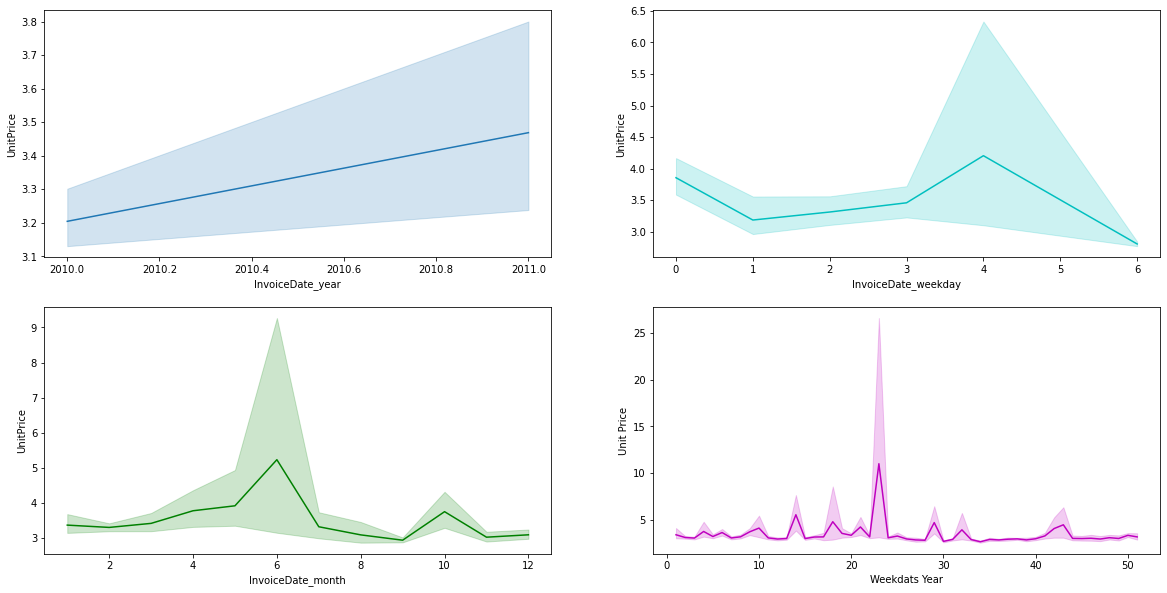

In [10]:
#Ploting the change of price over time period

fig, ax = plt.subplots(2,2, figsize = (20,10))
sns.lineplot(train_data.InvoiceDate_year, train_data.UnitPrice, ax = ax[0,0])
plt.xlabel('Year')
plt.ylabel('Unit Price')


sns.lineplot(train_data.InvoiceDate_month, train_data.UnitPrice, ax = ax[1,0], color = 'green')
plt.xlabel('Month')
plt.ylabel('Unit Price')


sns.lineplot(train_data.InvoiceDate_weekday, train_data.UnitPrice, ax = ax[0,1], color = 'c')
plt.xlabel('Weekdays')
plt.ylabel('Unit Price')

sns.lineplot(train_data.InvoiceDate_weekday_yr, train_data.UnitPrice, ax = ax[1,1], color = 'm')
plt.xlabel('Weekdats Year')
plt.ylabel('Unit Price')
# note: looking for seasonality impact on price

In [11]:
#Checking the sum of Unit Price over InvoiceDate_month

train_data.groupby('InvoiceDate_month')['UnitPrice'].sum().reset_index().sort_values(by='UnitPrice',ascending=False)

,InvoiceDate_month,UnitPrice
10,11,138946.730
9,10,132638.550
5,6,102385.210
11,12,96546.120
8,9,83841.202
4,5,79160.680
2,3,66292.840
6,7,64243.631
3,4,61228.571
7,8,59668.270


In [12]:
#Label Encoding the month filed. Giving maximum weight having maximum sell and minimum weight to minimum selling month

train_data['InvoiceDate_month']=train_data.InvoiceDate_month.apply(lambda x : 12 if x == 11 else(
11 if x == 10 else(
10 if x == 6 else (
9 if x == 12 else (
8 if x == 9 else (
7 if x == 5 else (
6 if x == 3 else (
5 if x == 7 else (
4 if x == 4 else (
3 if x == 8 else (
2 if x == 1 else 1 )))))))))))

test_data['InvoiceDate_month']=test_data.InvoiceDate_month.apply(lambda x : 12 if x == 11 else(
11 if x == 10 else(
10 if x == 6 else (
9 if x == 12 else (
8 if x == 9 else (
7 if x == 5 else (
6 if x == 3 else (
5 if x == 7 else (
4 if x == 4 else (
3 if x == 8 else (
2 if x == 1 else 1 )))))))))))

In [13]:
#Aranging the products as per their avarage unit price

price_desc = train_data.groupby('Description')['UnitPrice'].mean().reset_index().sort_values(by='UnitPrice',ascending=False)

price_desc.head()

,Description,UnitPrice
1028,1043,781.587857
2356,2405,649.500000
869,882,496.340833
2099,2140,334.676469
3502,3571,156.111111


In [14]:
#Creating groups of product description on basis of their avarage price by rounding up to the celling value 
#and dividing by .5 (to create more bins)

price_desc['Rank'] = price_desc['UnitPrice'].apply(lambda x : int(np.ceil(x*0.5)))

price_rank = np.sort(price_desc.Rank.unique())
print(price_rank)

#Creating a dictionary to serial ranks

dic1 = {}
for i in range(0,len(price_rank)):
    dic1[price_rank[i]]=i+1

#Mapping the continus Rank Value to the serial rank values
price_desc['Rank'] = price_desc['Rank'].map(dic1)

[  1   2   3   4   5   6   7   8   9  10  11  13  14  15  17  18  19  20
  22  23  25  26  27  30  33  44  56  60  73  78  79 168 249 325 391]


In [15]:
#Creating a Dictionary to map our newly created rank values(weight) and corrosponding descriptons for label encoding

dict_price_desc=pd.Series(price_desc.Rank.values,index=price_desc.Description).to_dict()

#creating new feature Description_Rank after mapping Description values on basis of unitprice

train_data['Description_Bin'] = train_data['Description'].astype(int).map(dict_price_desc)
test_data['Description_Bin'] = test_data['Description'].astype(int).map(dict_price_desc)

print(train_data['Description_Bin'].nunique())

#filling the null Description_Rank values in test data. These are the descriptions those are not present in train set. Applying 1 as default value

test_data.Description_Bin.fillna(1 , inplace = True)

#Description_Rank was appearing as float in train dataset. I have reset it to int

test_data['Description_Bin'] = test_data['Description_Bin'].apply(np.int64) 

35


In [16]:
#Arranging the avarage unit price of each product on monthly basis

price_month =train_data.groupby(['InvoiceDate_month','Description']).agg('UnitPrice').mean().reset_index().sort_values(by='UnitPrice', ascending = False)
price_month.head()

,InvoiceDate_month,Description,UnitPrice
21359,10,2140,2650.538
17961,9,1043,1599.260
25628,12,1043,1301.335
17848,9,882,1100.440
6772,4,1066,993.930


In [17]:
#Creating groups of product description on basis of their avarage price by rounding up to the celling value 

price_month['Rank'] = price_month['UnitPrice'].apply(lambda x : int(np.ceil(x)))

#Creating a Dictionary to map our newly created rank values(weight) and corrosponding descriptons for label encoding

dict_price_month=pd.Series(price_month.Rank.values,index=price_month.Description).to_dict()

#creating new feature Month_Rank after mapping Description values on basis of unitprice per month

train_data['Month_Bin'] = train_data['Description'].map(dict_price_month)
test_data['Month_Bin'] = test_data['Description'].map(dict_price_month)

print(train_data['Month_Bin'].nunique())
#filling the null Description_bin values in test data. These are the descriptions those are not present in train set. Applying forward fill to inject randomness

test_data.Month_Bin.ffill(inplace = True)

#Month_Rank was appearing as float in train dataset. I have reset it to int

test_data['Month_Bin'] = test_data['Month_Bin'].apply(np.int64) 

# NOTE: I hav not applied serial bining values in Month_Rank as I noticed that the value of the feature3 Rank is very close to actual predicted Unit PRice

41


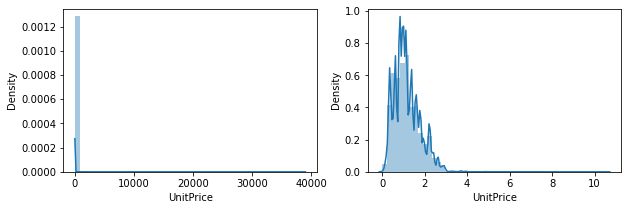

In [18]:
#Visualizing target filed(UnitPrice)
fig, ax = plt.subplots(1,2, figsize = (10,3))

sns.distplot(train_data.UnitPrice , ax = ax[0])
sns.distplot(np.log1p(train_data.UnitPrice) , ax = ax[1])

#Here I tried to plot the UnitPrice so that I can have a idea how it is distributed. The left picture is the data plotted as it is
#and the right one after taking log. As we can see after taking log data is well distributed we will take log before processing it.

In [19]:
train_data.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDate_year,InvoiceDate_month,InvoiceDate_weekday,InvoiceDate_weekday_yr,Description_Bin,Month_Bin
0,6141,1583,144,3,2011-05-06 16:54:00,3.75,14056,35,2011,7,4,18,2,4
1,6349,1300,3682,6,2011-05-11 07:35:00,1.95,13098,35,2011,7,2,19,1,2
2,16783,2178,1939,4,2011-11-20 13:20:00,5.95,15044,35,2011,12,6,46,3,6


In [20]:
test_data.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,CustomerID,Country,InvoiceDate_year,InvoiceDate_month,InvoiceDate_weekday,InvoiceDate_weekday_yr,Description_Bin,Month_Bin
0,3139,1709,1079,3,2011-02-22 15:22:00,16161,35,2011,1,1,8,1,2
1,617,510,3457,1,2010-12-08 12:46:00,17341,35,2010,9,2,49,1,2
2,14653,604,694,36,2011-10-25 13:53:00,15158,35,2011,11,1,43,2,4


### Summary on New Features 

1. Created four new date feature (InvoiceDate_year,InvoiceDate_month,InvoiceDate_weekday,InvoiceDate_weekday_yr) by decomposing 'InvoiceDate'.


2. Created new feature 'Description_Bin' by bining 'Description' into 35 segments on basis of 'UnitPrice'.


3. Created new feature 'Month_Bin' by bining 'Description' into 41 segments on basis of monthly 'UnitPrice'.

## Data Preperation(1)

I used GradientBoosting and CatBoosting models to predict the price. However, these models didn't worked very well for my case. XGBoost worked well for me.
However, my model score was stuck at a certain level using XGBoost too.
Finally, I took an approach of first creating one XGBoost model with my training data and use the prediction of the first model as a feature to my second and third XGBost model iteratively.
This approach worked better for me. 






In [21]:
#Removing unnecessory columns and for my first model

train_data_1 = train_data.drop(['InvoiceDate','InvoiceNo','Quantity','Description'], axis = 1)
test_data_1 = test_data.drop(['InvoiceDate','InvoiceNo','Quantity','Description'], axis = 1)

In [22]:
# Creating the dependent and independent features

train_feature = train_data_1.drop(['UnitPrice'], axis = 1)
train_label =  train_data_1['UnitPrice']

In [23]:
#Splitting the data for training and validation into 7:3 test:validation ratio with random state 42

train_x,val_x,train_y,val_y=train_test_split(train_feature,train_label,test_size=0.30,random_state=42)

In [24]:
#scalling the data set

scaller = MinMaxScaler()
train_x = scaller.fit_transform(train_x,train_y)
val_x = scaller.transform(val_x)
test_data_scalled = scaller.transform(test_data_1)

## ML Model Building (1)

In [25]:
#Creating my first XGBoost model

XGBModel1 = XGBRegressor(n_estimators=350, max_depth=12, learning_rate=0.12,subsample = 0.5,reg_lambda=0.005)
XGBModel1.fit(train_x,np.log1p(train_y))

#Measuring the performance with RMSE Score for XGBModel1

print('RMSE Score---')
pred_train = np.expm1(XGBModel1.predict(train_x)) 
print('Train      :', np.sqrt(mean_squared_error(train_y,pred_train))) # RMSE Score for training data set

pred = np.expm1(XGBModel1.predict(val_x))
print('Validation :',np.sqrt(mean_squared_error(val_y,pred))) # RMSE Score for validation data set

#Measuring the performance with R2 Score for training and validation data

print('R2 Score---')
print('Train      :', r2_score(train_y,pred_train))
print('Validation :', r2_score(val_y,pred))

RMSE Score---
Train      : 6.3198989719776675
Validation : 136.82362750078624
R2 Score---
Train      : 0.9309613628893496
Validation : 0.021809571128093785


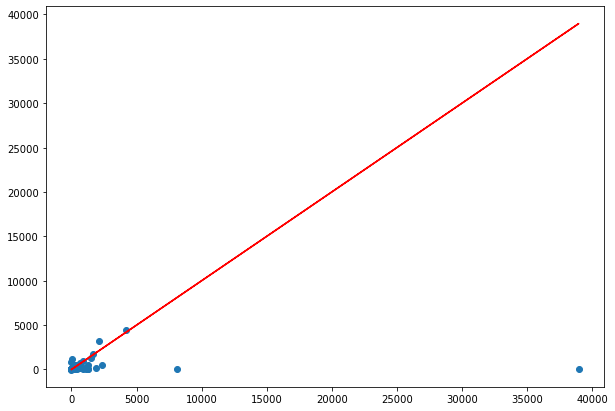

In [26]:
#ploting the prediction for XGBRegressor

plt.figure(figsize=(10,7))
plt.scatter(val_y,pred)
plt.plot(val_y,val_y,'r')

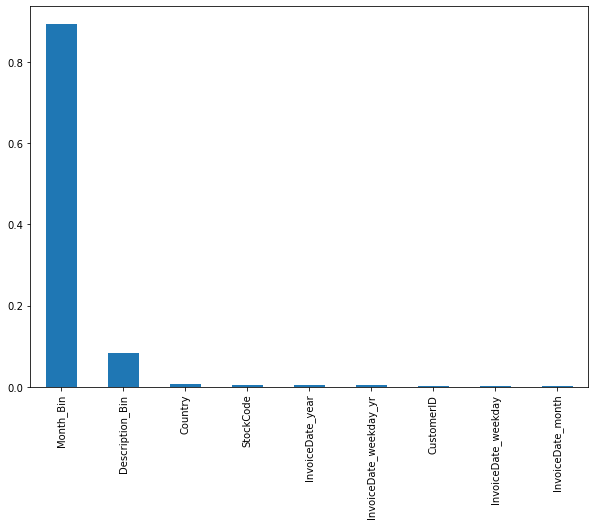

In [27]:
#Displaying the important features for 

imp_feat=pd.Series(XGBModel1.feature_importances_,index=train_feature.columns)
plt.figure(figsize=(10,7))
imp_feat.sort_values(ascending=False).plot(kind='bar')

In [28]:
#Scalling the whole traning set for new 

train_data_scalled = scaller.transform(train_feature)

#Final Prediction of Price on complete training data set and unseen new dataset.

XGBModel1_pred_train = np.expm1(XGBModel1.predict(train_data_scalled))
XGBModel1_pred_test = np.expm1(XGBModel1.predict(test_data_scalled))

In [29]:
#Convering result into new feature

train_data['XBGOutput']=pd.Series(XGBModel1_pred_train.flatten())
test_data['XBGOutput']=pd.Series(XGBModel1_pred_test.flatten())


In [30]:
#Looking at the final data set after phase 2

train_data.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDate_year,InvoiceDate_month,InvoiceDate_weekday,InvoiceDate_weekday_yr,Description_Bin,Month_Bin,XBGOutput
0,6141,1583,144,3,2011-05-06 16:54:00,3.75,14056,35,2011,7,4,18,2,4,3.772495
1,6349,1300,3682,6,2011-05-11 07:35:00,1.95,13098,35,2011,7,2,19,1,2,1.935282
2,16783,2178,1939,4,2011-11-20 13:20:00,5.95,15044,35,2011,12,6,46,3,6,5.966130


In [31]:
test_data.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,CustomerID,Country,InvoiceDate_year,InvoiceDate_month,InvoiceDate_weekday,InvoiceDate_weekday_yr,Description_Bin,Month_Bin,XBGOutput
0,3139,1709,1079,3,2011-02-22 15:22:00,16161,35,2011,1,1,8,1,2,1.645642
1,617,510,3457,1,2010-12-08 12:46:00,17341,35,2010,9,2,49,1,2,1.263222
2,14653,604,694,36,2011-10-25 13:53:00,15158,35,2011,11,1,43,2,4,4.196516


## Data Preperation(2)

In [32]:
#Droping unnecessory columns for the 2nd XGBoost model
#Here, removing earlier created feature 'Description_Bin','Month_Bin' as more powerful feature 'XBGOutput' has been created

train_data_2 = train_data.drop(['InvoiceDate','InvoiceNo','Quantity','Description_Bin','Month_Bin'], axis = 1)
test_data_2 = test_data.drop(['InvoiceDate','InvoiceNo','Quantity','Description_Bin','Month_Bin'], axis = 1)

In [33]:
# Creating the dependent and independent features

train_feature_2 = train_data_2.drop(['UnitPrice'], axis = 1)
train_label_2 =  train_data_2['UnitPrice']

In [34]:
#Splitting the data for training and validation with 9:1 ratio for train:validation

train_x_2,val_x_2,train_y_2,val_y_2 = train_test_split(train_feature_2,train_label_2,test_size=0.01,random_state=42)

In [35]:
#Scalling the data:

train_x_2 = scaller.fit_transform(train_x_2,train_y_2)
val_x_2 = scaller.transform(val_x_2)
test_data_scalled_2 = scaller.transform(test_data_2)

## ML Model Building (2)

In [36]:
#Creating my Second XGBoost model

XGBModel2 = XGBRegressor(n_estimators=400, max_depth=12, learning_rate=0.2,subsample = 0.5,reg_lambda=0.003)
XGBModel2.fit(train_x_2,np.log1p(train_y_2))

#Measuring the performance with RMSE Score for XGBModel2

print('RMSE Score---')
pred_train_2 = np.expm1(XGBModel2.predict(train_x_2)) 
print('Train      :', np.sqrt(mean_squared_error(train_y_2,pred_train_2))) # RMSE Score for training data set

pred_2 = np.expm1(XGBModel2.predict(val_x_2))
print('Validation :',np.sqrt(mean_squared_error(val_y_2,pred_2))) # RMSE Score for validation data set

#Measuring the performance with R2 Score for training and validation data

print('R2 Score---')
print('Train      :', r2_score(train_y_2,pred_train_2))
print('Validation :', r2_score(val_y_2,pred_2))

# RMSE Score---
# Train      : 6.636998358057048
# Validation :  236.10993922513308
# R2 Score---
# Train      : 0.9254565482498727
# Validation :  0.007048235571451178

# RMSE Score---
# Train      : 7.188644338699648
# Validation : 18.415815942978092
# R2 Score---
# Train      : 0.9916651518700481
# Validation : 0.5964828705435425

RMSE Score---
Train      : 7.188644338699648
Validation : 18.415815942978092
R2 Score---
Train      : 0.9916651518700481
Validation : 0.5964828705435425


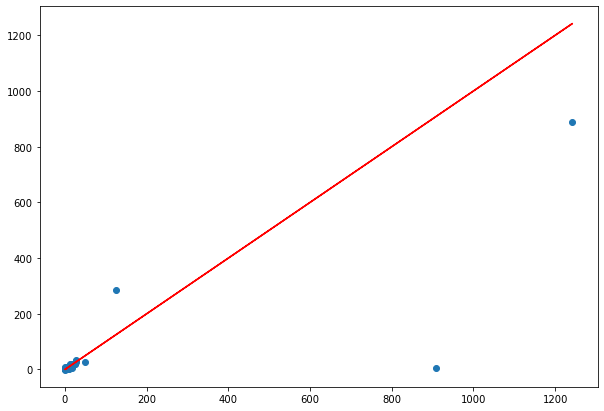

In [37]:
#ploting the prediction for XGBRegressor

plt.figure(figsize=(10,7))
plt.scatter(val_y_2,pred_2)
plt.plot(val_y_2,val_y_2,'r')

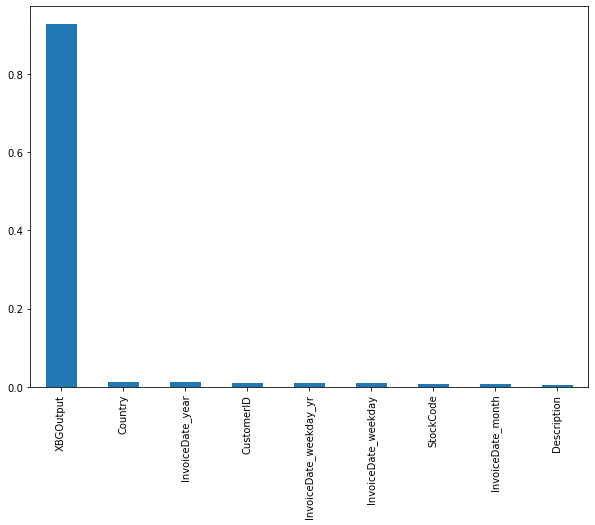

In [38]:
#Displaying the important features for 

imp_feat=pd.Series(XGBModel2.feature_importances_,index=train_feature_2.columns)
plt.figure(figsize=(10,7))
imp_feat.sort_values(ascending=False).plot(kind='bar')

In [39]:
#Scalling the whole traning set for 3rd xgbmodel 

train_data_scalled_2 = scaller.transform(train_feature_2)

#Final Prediction of Price on complete training data set and unseen new dataset.

XGBModel2_pred_train = np.expm1(XGBModel2.predict(train_data_scalled_2))
XGBModel2_pred_test = np.expm1(XGBModel2.predict(test_data_scalled_2))

In [40]:
#Convering result into 3rd XGBModel

train_data['XBGOutput2']=pd.Series(XGBModel2_pred_train.flatten())
test_data['XBGOutput2']=pd.Series(XGBModel2_pred_test.flatten())

In [41]:
train_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDate_year,InvoiceDate_month,InvoiceDate_weekday,InvoiceDate_weekday_yr,Description_Bin,Month_Bin,XBGOutput,XBGOutput2
0,6141,1583,144,3,2011-05-06 16:54:00,3.75,14056,35,2011,7,4,18,2,4,3.772495,3.750324
1,6349,1300,3682,6,2011-05-11 07:35:00,1.95,13098,35,2011,7,2,19,1,2,1.935282,1.941332
2,16783,2178,1939,4,2011-11-20 13:20:00,5.95,15044,35,2011,12,6,46,3,6,5.966130,5.947136
3,16971,2115,2983,1,2011-11-22 12:07:00,0.83,15525,35,2011,12,1,47,1,1,0.828130,0.831826
4,6080,1210,2886,12,2011-05-06 09:00:00,1.65,13952,35,2011,7,4,18,1,2,1.677277,1.656439


In [42]:
test_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,CustomerID,Country,InvoiceDate_year,InvoiceDate_month,InvoiceDate_weekday,InvoiceDate_weekday_yr,Description_Bin,Month_Bin,XBGOutput,XBGOutput2
0,3139,1709,1079,3,2011-02-22 15:22:00,16161,35,2011,1,1,8,1,2,1.645642,1.643720
1,617,510,3457,1,2010-12-08 12:46:00,17341,35,2010,9,2,49,1,2,1.263222,1.241195
2,14653,604,694,36,2011-10-25 13:53:00,15158,35,2011,11,1,43,2,4,4.196516,4.230935
3,8634,1478,3473,2,2011-06-27 12:38:00,16033,35,2011,10,0,26,1,2,1.644490,1.652604
4,15546,3216,871,1,2011-11-06 16:14:00,15351,35,2011,12,6,44,7,13,12.775178,12.799099


## Data Preperation(3)

In [43]:
#Droping unnecessory columns for the 2nd XGBoost model
#Here, removing earlier created feature 'Description_Bin','Month_Bin' and 'XBGOutput' as more powerful feature 'XBGOutput' has been created

train_data_3 = train_data.drop(['InvoiceDate','InvoiceNo','Quantity','Description_Bin','Month_Bin','XBGOutput'], axis = 1)
test_data_3 = test_data.drop(['InvoiceDate','InvoiceNo','Quantity','Description_Bin','Month_Bin','XBGOutput'], axis = 1)

In [44]:
# Creating the dependent and independent features

train_feature_3 = train_data_3.drop(['UnitPrice'], axis = 1)
train_label_3 =  train_data_3['UnitPrice']

In [45]:
#Splitting the data for training and validation with 9:1 ratio for train:validation

train_x_3,val_x_3,train_y_3,val_y_3 = train_test_split(train_feature_3,train_label_3,test_size=0.01,random_state=42)

In [46]:
#Scalling the data:

train_x_3 = scaller.fit_transform(train_x_3,train_y_3)
val_x_3 = scaller.transform(val_x_3)
test_data_scalled_3 = scaller.transform(test_data_3)

## ML Model Building (3)

In [47]:
#Creating my Second XGBoost model

XGBModel3 = XGBRegressor(n_estimators=400, max_depth=12, learning_rate=0.205,subsample = 0.5,reg_lambda=0.003)
XGBModel3.fit(train_x_3,np.log1p(train_y_3))

#Measuring the performance with RMSE Score for XGBModel2

print('RMSE Score---')
pred_train_3 = np.expm1(XGBModel3.predict(train_x_3)) 
print('Train      :', np.sqrt(mean_squared_error(train_y_3,pred_train_3))) # RMSE Score for training data set

pred_3 = np.expm1(XGBModel3.predict(val_x_3))
print('Validation :',np.sqrt(mean_squared_error(val_y_3,pred_3))) # RMSE Score for validation data set

#Measuring the performance with R2 Score for training and validation data

print('R2 Score---')
print('Train      :', r2_score(train_y_3,pred_train_3))
print('Validation :', r2_score(val_y_3,pred_3))

# RMSE Score---
# Train      : 7.976992052594598
# Validation : 18.446563620940353
# R2 Score---
# Train      : 0.9897368183606798
# Validation : 0.5951342935874209

RMSE Score---
Train      : 7.914275194918363
Validation : 18.328920619622053
R2 Score---
Train      : 0.989897566708687
Validation : 0.6002818905940155


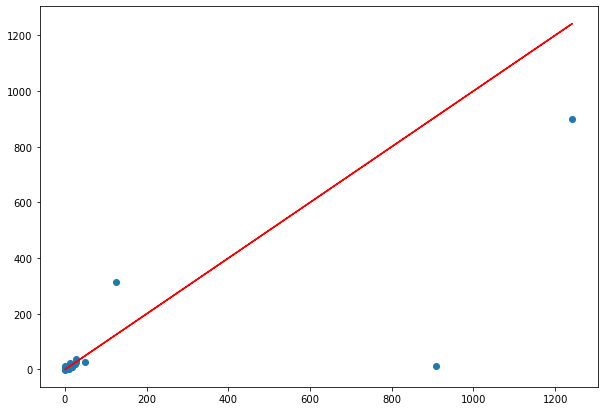

In [48]:
#ploting the prediction for XGBRegressor

plt.figure(figsize=(10,7))
plt.scatter(val_y_3,pred_3)
plt.plot(val_y_3,val_y_3,'r')

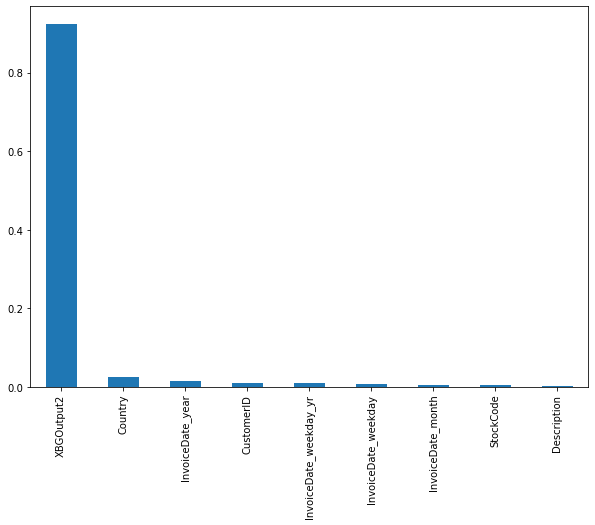

In [49]:
#Displaying the important features for 

imp_feat=pd.Series(XGBModel3.feature_importances_,index=train_feature_3.columns)
plt.figure(figsize=(10,7))
imp_feat.sort_values(ascending=False).plot(kind='bar')

### Final Prediction on Unseen Dataset

In [50]:
#Final Prediction of Price on completely unseen new dataset.

final_pred = np.expm1(XGBModel3.predict(test_data_scalled_3))

#Convering prediction in Pandas dataframe
result = pd.DataFrame()
result['UnitPrice']=pd.Series(final_pred.flatten())

#Final Result
result.head()

,UnitPrice
0,1.648438
1,1.252611
2,4.242200
3,1.650958
4,10.483052


In [51]:
# Exporting result to CSV ('Sample Submission.csv')

result.to_csv('Sample Submission.csv',index=False)